In [46]:
import datetime
import json
from urllib.request import urlopen

import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.graph_objs.scatter.marker import Line

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
from jupyter_dash import JupyterDash

In [86]:
state_count = pd.read_csv("state_case.csv")
state_mandate = pd.read_csv("state_mandates.csv")

## Case count dataset processing

In [87]:
state_count = state_count[['state','submission_date','new_case','new_death']]
state_count = state_count.rename(columns = {'submission_date':'date'})
state_count['date'] = pd.to_datetime(state_count['date'])

In [88]:
state_count

,state,date,new_case,new_death
0,CO,2020-01-22,0,0
1,CO,2020-01-23,0,0
2,CO,2020-01-24,0,0
3,CO,2020-01-25,0,0
4,CO,2020-01-26,0,0
...,...,...,...,...
19057,PW,2020-11-30,0,0
19058,PW,2020-12-01,0,0
19059,PW,2020-12-02,0,0
19060,PW,2020-12-03,0,0


In [89]:
state_count['month'] = pd.to_datetime(state_count['date']).dt.month
state_count_monthly = state_count.groupby(['state','month']).sum().reset_index()

In [90]:
state_count_monthly

,state,month,new_case,new_death
0,AK,1,0,0
1,AK,2,0,0
2,AK,3,133,3
3,AK,4,222,6
4,AK,5,105,1
...,...,...,...,...
715,WY,8,1116,11
716,WY,9,2106,13
717,WY,10,7350,37
718,WY,11,20007,128


In [76]:
state_count_Oct = state_count_monthly[state_count_monthly['month'] == 10]

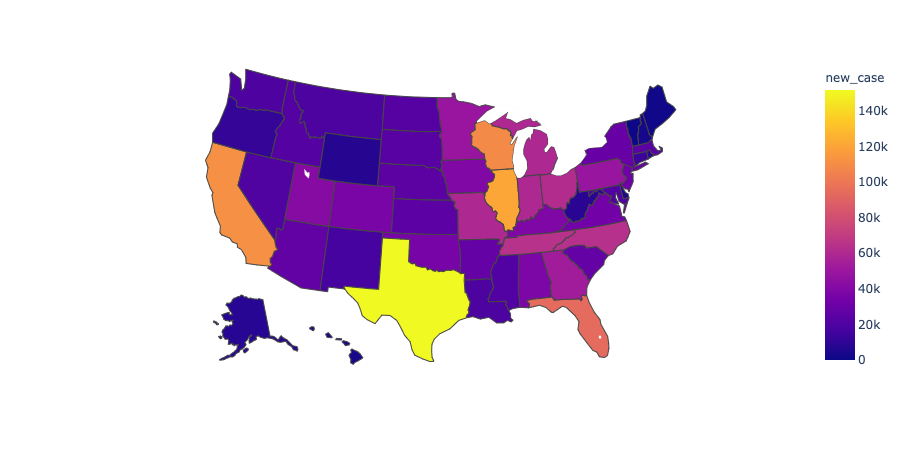

In [77]:
fig = px.choropleth(state_count_Oct, color = 'new_case', locations='state', locationmode="USA-states", scope="usa")
fig.show()

In [78]:
CA_case_count = state_count[state_count['state'] == 'CA']
TX_case_count = state_count[state_count['state'] == 'TX']

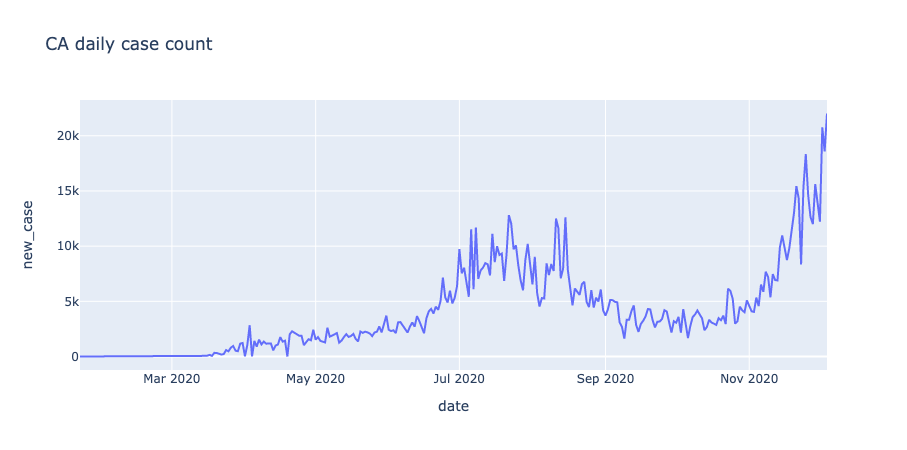

In [79]:
CA_fig = px.line(CA_case_count, x = CA_case_count['date'], y = CA_case_count['new_case'], 
                 title='CA daily case count')
CA_fig.show()

## State mandate processing

In [92]:
state_mandate = state_mandate.rename(columns = {'state':'state_fullname', 'state_id':'state'})

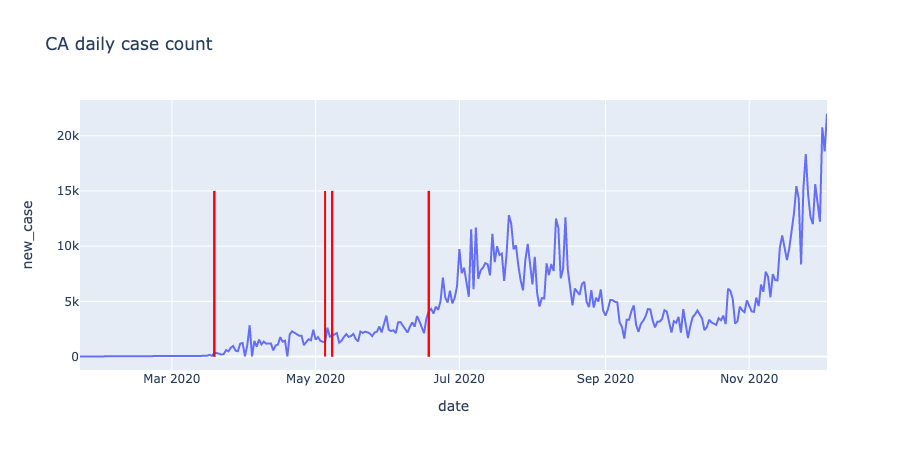

In [94]:
CA_fig = px.line(CA_case_count, x = CA_case_count['date'], y = CA_case_count['new_case'], 
                 title='CA daily case count')
CA_main_policy = state_mandate[state_mandate['state'] == 'CA']
for date in CA_main_policy['date']:
    CA_fig.add_shape(type='line',
                    x0=date,
                    y0=0,
                    x1=date,
                    y1=15000,
                    line=dict(color='Red',),
                    xref='x',
                    yref='y'
    ) 
CA_fig.show()

## Dashboard creating

In [95]:
## create the app
app = JupyterDash(__name__)

In [96]:
## create the app layout: it includes two of the three components of dash: plotly figure and dash core components.
## App layout
app.layout = html.Div([
    
    html.H1("Covid-policy Visualization", style={'text-align':'center'}),
    
    dcc.Slider(id="slct_month",
               min=state_count_monthly['month'].min(),
               max=state_count_monthly['month'].max(),
               value=state_count_monthly['month'].min(),
               marks={i: '{}'.format(i) for i in range(1, 13)} 
    ),
    
    html.Div([
        dcc.Graph(id='state_choropleth')
    ]),
    
    html.Label("Line plot for the chosen states"),
    html.Div(["User's input: ",
        dcc.Input(id="state_input_1", type='text', value='CA'),
        dcc.Input(id="state_input_2", type='text', value='TX'),
        html.Button(id='submit_button', n_clicks=0, children = 'Submit')
    ],
    style={
        'borderBottom': 'thin lightgrey solid',
        'backgroundColor': 'rgb(250, 250, 250)',
        'padding': '10px 5px'}),
    
    html.Div([
        dcc.Graph(id='line_plot_1')
    ],
    style={'width':'49%','display':'inline-block'}),
    
    html.Div([
        dcc.Graph(id='line_plot_2')
    ],
    style={'width':'49%','display':'inline-block','float':'right'})
    
])

In [97]:
## connect the dash components with plotly graph by callback
@app.callback(
    Output(component_id='state_choropleth', component_property='figure'),
    Input(component_id='slct_month', component_property='value')
)
def update_choropleth_graph(option_slctd):
    
    state_count_monthly_cp = state_count_monthly.copy()
    state_count_monthly_cp = state_count_monthly_cp[state_count_monthly_cp['month'] == option_slctd]
    
    fig = px.choropleth(state_count_monthly_cp, 
                        color = 'new_case', 
                        locations='state', 
                        locationmode="USA-states", 
                        scope="usa")
    
    fig.update_layout(transition_duration=500)
    
    return fig

@app.callback(
    Output(component_id='line_plot_1', component_property='figure'),
    Output(component_id='line_plot_2', component_property='figure'),
    Input(component_id='submit_button', component_property='n_clicks'),
    State(component_id='state_input_1', component_property='value'),
    State(component_id='state_input_2', component_property='value')
)
def update_lineplot_graph(n_clicks, input1, input2):
    
    state_count_cp = state_count.copy()
    state_count_cp_1 = state_count_cp[state_count_cp["state"] == input1]
    state_count_cp_2 = state_count_cp[state_count_cp["state"] == input2]
    
    state_mandate_cp = state_mandate.copy()
    state_mandate_cp_1 = state_mandate_cp[state_mandate_cp["state"] == input1]
    state_mandate_cp_2 = state_mandate_cp[state_mandate_cp["state"] == input2]
    
    fig1 = px.line(state_count_cp_1, x = state_count_cp_1['date'], y = state_count_cp_1['new_case'], 
                   title=input1 + " daily case count")
    
    for date in state_mandate_cp_1['date']:
        fig1.add_shape(type='line',
                        x0=date,
                        y0=0,
                        x1=date,
                        y1=15000,
                        line=dict(color='Red',),
                        xref='x',
                        yref='y'
        ) 
    
    fig2 = px.line(state_count_cp_2, x = state_count_cp_2['date'], y = state_count_cp_2['new_case'], 
                   title=input2 + " daily case count")
    
    for date in state_mandate_cp_2['date']:
        fig2.add_shape(type='line',
                        x0=date,
                        y0=0,
                        x1=date,
                        y1=15000,
                        line=dict(color='Red',),
                        xref='x',
                        yref='y'
        ) 
    
    return fig1, fig2

In [98]:
app.run_server(mode='jupyterlab',debug = True, dev_tools_hot_reload=True)